In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # Инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # Алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# Для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1083.3673325086174
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5665.68875094349


In [11]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

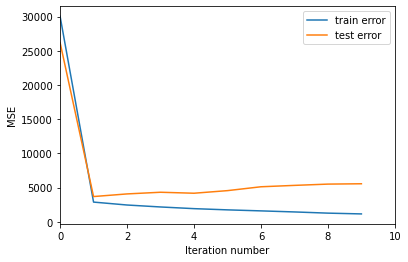

In [12]:
get_error_plot(n_trees, train_errors, test_errors)

1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [13]:
def plot_trees_error(X_train, X_test, y_train, y_test, max_depth, eta):  
    
    trees = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    train_results = [] 
    test_results = []
    
    for tree in trees:
        n_trees = tree
        coefs = [1] * n_trees
        t, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, t, coefs, eta)
        test_prediction = gb_predict(X_test, t, coefs, eta)
        train_r = mean_squared_error(y_train, train_prediction)
        test_r = mean_squared_error(y_test, test_prediction)
        train_results.append(train_r)
        test_results.append(test_r)
                
    plt.xlabel('Trees number')
    plt.ylabel('MSE')
    plt.plot(trees, train_results, label='train error')
    plt.plot(trees, test_results, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [14]:
def plot_depth_error(X_train, X_test, y_train, y_test, n_trees, eta):  
    
    depths = [1, 2, 3, 4, 5]
    train_results = [] 
    test_results = []
    
    for depth in depths:
        coefs = [1] * n_trees
        t, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_prediction = gb_predict(X_train, t, coefs, eta)
        test_prediction = gb_predict(X_test, t, coefs, eta)
        train_r = mean_squared_error(y_train, train_prediction)
        test_r = mean_squared_error(y_test, test_prediction)
        train_results.append(train_r)
        test_results.append(test_r)
                
    plt.xlabel('Depths number')
    plt.ylabel('MSE')
    plt.plot(depths, train_results, label='train error')
    plt.plot(depths, test_results, label='test error')
    plt.legend(loc='upper right')
    plt.show()

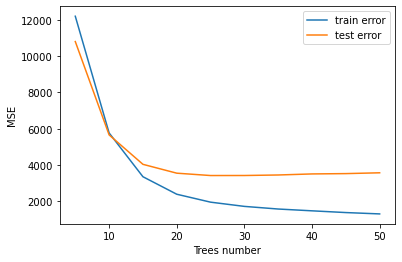

In [15]:
plot_trees_error(X_train, X_test, y_train, y_test, max_depth = 3, eta = 0.1)


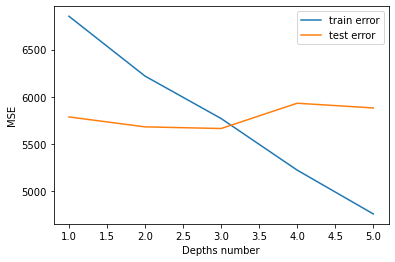

In [22]:
plot_depth_error(X_train, X_test, y_train, y_test, n_trees = 10, eta = 0.1)

По графику с деревьями можно увидеть, что ошибка падает до 20-25 деревьев, а далее кривая выравнивается и становится похожей на плато. По глубине видно, что ошибка постоянно падает на тренировочных данных, но на тестовой до 2 (от чего продолжает немного падать до 3), затем снова растёт. Соответственно, происходит переобучение. Глядя на оба графика можно судить о том, что оптимальным выбором деревьев будет около 25, а глубины - от 2 до 3 (при шаге 0.1). После проверки оказалось, что глубина 3 - самая оптимальная. При этих значениях не такой большой разрыв ошибки между тренировочной выборкой и тестовой, а также самая маленькая ошибка на тесте.

In [17]:
# Число деревьев в ансамбле
n_trees = 25

# Для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.1 на тренировочной выборке: 2551.038816274818
Ошибка алгоритма из 25 деревьев глубиной 2     с шагом 0.1 на тестовой выборке: 3428.5204351168704


2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [18]:
def stoch_gb_fit(n_trees_s, max_depth, X_train, X_test, y_train, y_test, coefs, eta):

# Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors_s = []
    test_errors_s = []
    
    # Найдём количество батчей
    n = X_train.shape[0]
    n_batch = 1/0.5  
    qty_in_batch = int(n // n_batch) 
    
    for i in range(n_trees_s):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # Создаём батч и применяем к выборкам
        batch = np.random.randint(n_batch)      
        start = qty_in_batch * batch
        end = qty_in_batch * (batch + 1)
        X_train_ = X_train[start:end, :]
        y_train_ = y_train[start:end]
        
        # Инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_, y_train_)
            
            train_errors_s.append(mean_squared_error(y_train_, gb_predict(X_train_, trees, coefs, eta)))
            test_errors_s.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_, trees, coefs, eta)
            
            # Алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train_, bias(y_train_, target))
            
            train_errors_s.append(mean_squared_error(y_train_, gb_predict(X_train_, trees, coefs, eta)))
            test_errors_s.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors_s, test_errors_s

In [19]:
# Число деревьев в ансамбле
n_trees_s = 10

# Для простоты примем коэффициенты равными 1
coefs = [1] * n_trees_s

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors_s, test_errors_s = stoch_gb_fit(n_trees_s, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [20]:
def get_stoch_error_plot(n_trees_s, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees_s)
    plt.plot(list(range(n_trees_s)), train_err, label='train error')
    plt.plot(list(range(n_trees_s)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

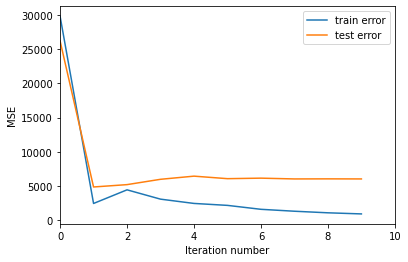

In [21]:
get_error_plot(n_trees_s, train_errors_s, test_errors_s)

При стохастическом градиентном бустинге наблюдаются скачки (при обычном градиентном бустинге после резкого падения ошибки набюдается плато). Сперва ошибка резко падает, как и при обычном градиентном бустинге, но затем с новыми итерациями то растёт, то падает (на тренировочных данных), а на тестовых продолжает расти. При повторном запуске кода график немного меняется (на тех же данных).